# Flash Attention

Objective of this notebook is to understand how flash attention works by implementing it in pytorch. This implementation is **NOT** meant to improve performance. I did this exercise to understand the concept and spelling it out in code helps me better understand and retain information.

In [13]:
import torch
import torch.nn as nn

## Online Softmax

Before getting the details of flash attentions its important to understand "online softmax" since its a key component of Flash Attention.

Before is an implementation of softmax in pytorch

### Softmax

In [14]:
def softmax(x: torch.tensor) -> torch.tensor:
    max_x = torch.max(x, dim=-1, keepdims=True)[0] # extracting the value
    exp_x = torch.exp(x - max_x)
    sum_exp_x = torch.sum(exp_x, dim=-1, keepdims=True)
    return exp_x / (sum_exp_x)

In [15]:
# Check Correctness with PyTorch Softmax
x = torch.randn(1, 20)
y_py = softmax(x)
y_pyt = torch.softmax(x, dim=-1,)
torch.allclose(y_py, y_pyt)

True

### Naive Softmax

If we look closely at the above implementation, pytorch makes the implementation very easy but underneath there are 3 for-loops that are running sequentially.
1. compute max of the row.
2. compute the sum of the diff of each element and max.
3. compute the exp of each element and divide by the sum computed in step 2.


See below implementation

In [ ]:
# %%timeit
# Naive Softmax

torch.manual_seed(123)
x = torch.randn(2000)
naive_sf = torch.empty_like(x)
#print("---- Input -----")
#print(x)

m = torch.tensor(float('-inf'))

# 1.
for i in range(x.shape[0]):
    m = torch.max(m, x[i])

# print("---- Max ----")
# print(m)
exp_sum = 0

# 2.
for i in range(x.shape[0]):
    exp_sum += torch.exp(x[i] - m)

# print("---- Sum ----")
# print(exp_sum)

# 3.
for i in range(x.shape[0]):
    naive_sf[i] = torch.exp(x[i] - m) / exp_sum

# print("---- Softmax ----")
# print(out)


### Online Softmax
paper link - https://arxiv.org/abs/1805.02867
Goal of this paper is to parallelize softmax to improve performance. The problem with the naive implementation is step 1 and step 2 are dependent and hence sequential. However this doesn't have to be the case. We can compute a max of a small block and compute the exp_sum for the local block. But the local max may not be the global max, right? \
Turns out to adjust for this difference, we just need to scale the `exp_sum` with $e^{(max\_prev - max\_new)}$

See below implementation

In [ ]:
# %%timeit
# Online Softmax

torch.manual_seed(123)
x = torch.randn(2000)
online_sf = torch.empty_like(x)
# print("---- Input -----")
# print(x)

m = torch.tensor(float('-inf'))
exp_sum = torch.tensor(0.0)

for i in range(x.shape[0]):
    m_prev = m
    m = torch.max(m_prev, x[i])
    exp_sum = (exp_sum * torch.exp(m_prev - m) + torch.exp(x[i] - m))

# print("---- Max ----")
# print(m)

# print("---- Sum ----")
# print(exp_sum)

for i in range(x.shape[0]):
    online_sf[i] = torch.exp(x[i] - m) / exp_sum

# print("---- Out ----")
# print(out)
    

In [ ]:
torch.allclose(online_sf, naive_sf)

### Scaled Dot Product
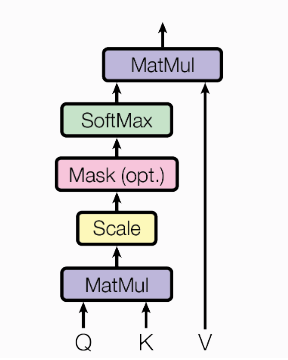
<img src="images/img2.png" width="300" height="80">

In [16]:
import torch
torch.manual_seed(123)
N, d = 20, 10
q = torch.rand(N, d)
k = torch.rand(N, d)
v = torch.rand(N, d)

attn_scores = q @ k.T
attn_weights = torch.softmax(attn_scores, dim=-1)
baseline_out = attn_weights @ v

baseline_out.shape

torch.Size([20, 10])

### Flash Attention V1

Flash Attention at its core is basically exploiting the memory hierarchy of GPU memory system. It breaks the big matrices into blocks that fit into SRAM (on-chip) memory. Please read the [paper](https://arxiv.org/abs/2205.14135) to get more details.
<img src="images/img3.png" width="500" height="500">

Flash Attention uses the concept of tiling which basically breaks a big block into small chunks which fit into SRAM so that read and writes are super fast keeping the problem compute bound.
<img src="images/img4.png" width="300" height="300">



In [3]:
# flash attention
block_size = 5

Tr = N//block_size
Tc = N//block_size
fa_out = torch.zeros_like(q)
m = torch.ones(q.shape[0], 1) * float('-inf')
l = torch.zeros(q.shape[0], 1)
for j in range(Tc):
    j_range = range(j*block_size, block_size*(j+1))
    kj = k[j_range, :]
    vj = v[j_range, :]
    for i in range(Tr):
        i_range = range(i*block_size, (i+1)*block_size)
        qi = q[i_range, :]
        Oi = fa_out[i_range, :]
        Mi = m[i_range, :]
        Li = l[i_range, :]
        
        Sij = qi @ kj.T
        Mij = torch.max(Sij, dim=-1, keepdims=True)[0]
        Pij = torch.exp(Sij - Mij)
        Lij = torch.sum(Pij, dim=-1, keepdim=True)
        
        m_new = torch.max(Mi, Mij)
        l_new = torch.exp(Mi - m_new) * Li + torch.exp(Mij - m_new) * Lij
        Oi = (torch.exp(Mi - m_new) * Li * Oi) + (torch.exp(Mij - m_new) * (Pij @ vj))
        fa_out[i_range, :] = Oi / l_new
        m[i_range, :] = m_new
        l[i_range, :] = l_new
        

### Flash Attention V2
Forward pass

In [11]:
# flash attention v2
block_size = 5

Tr = N//block_size
Tc = N//block_size
fa_v2_out = torch.zeros_like(q)
m = torch.ones(q.shape[0], 1) * float('-inf')
l = torch.zeros(q.shape[0], 1)
for j in range(Tc):
    j_range = range(j*block_size, block_size*(j+1))
    kj = k[j_range, :]
    vj = v[j_range, :]
    for i in range(Tr):
        i_range = range(i*block_size, (i+1)*block_size)
        qi = q[i_range, :]
        Oi = fa_v2_out[i_range, :]
        Mi = m[i_range, :]
        Li = l[i_range, :]
        
        Sij = qi @ kj.T
        Mij = torch.max(Sij, dim=-1, keepdims=True)[0]
        m_new = torch.max(Mi, Mij)
        Pij = torch.exp(Sij - m_new)
        Lij = torch.sum(Pij, dim=-1, keepdim=True)
        
        
        l_new = torch.exp(Mi - m_new) * Li + Lij
        Oi = (torch.exp(Mi - m_new) * Oi) + (Pij @ vj)
        fa_v2_out[i_range, :] = Oi
        m[i_range, :] = m_new
        l[i_range, :] = l_new
fa_v2_out = fa_v2_out / l

In [12]:
print(torch.allclose(fa_out, baseline_out))
print(torch.allclose(fa_v2_out, baseline_out))

True
True
